## Importing Libraries

In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import plotly.express as px
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

## Loading the Data

In [160]:
df = pd.read_csv("Breast_Cancer.csv", header=0, delimiter=',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Dataset Inspection

In [161]:
numerical_cols = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
categorical_cols = ['Race','Marital Status','T Stage ','N Stage','6th Stage','differentiate','Grade','A Stage','Estrogen Status','Progesterone Status']

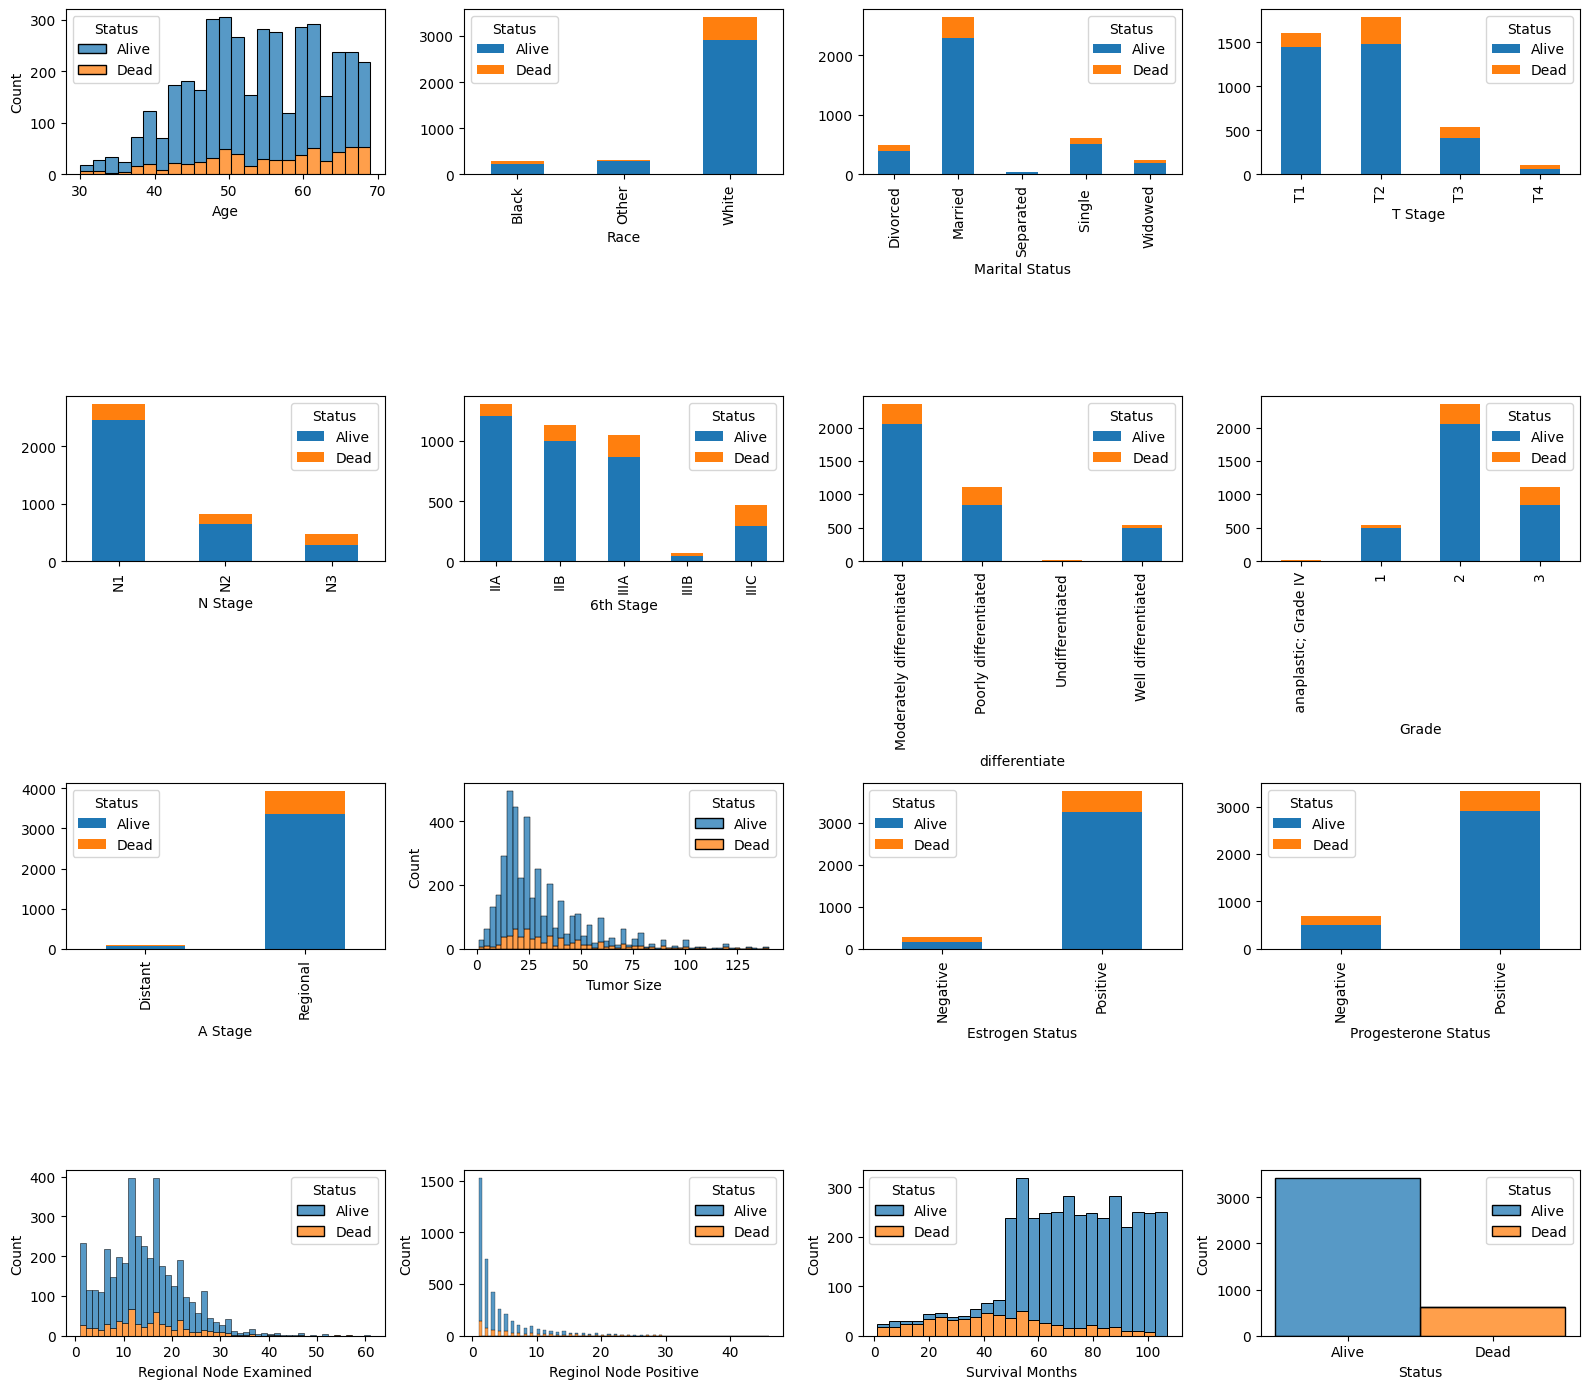

In [162]:
fig, axes = plt.subplots(4,4,figsize=(16,14))

for i, c in enumerate(df.columns):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        ct = pd.crosstab(index=df[c], columns=df['Status'])
        a = ct.plot(kind='bar', stacked=True,ax=ax)
    else: 
        sns.histplot(x=c,data=df, hue='Status',ax=ax, multiple='stack')
plt.tight_layout()

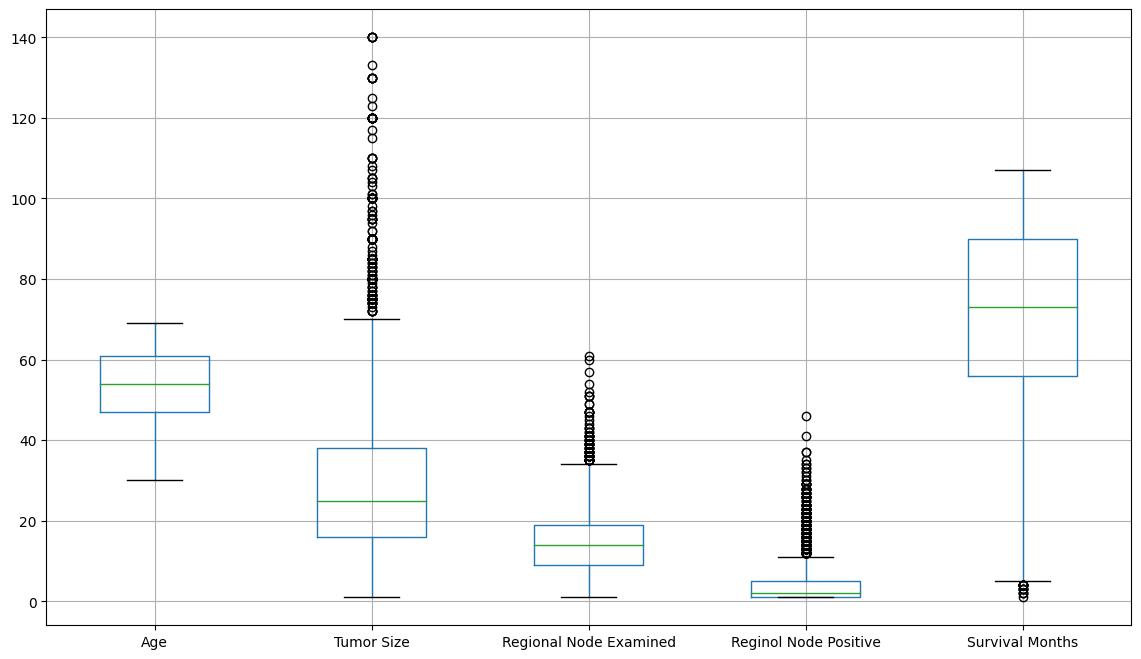

In [163]:
df.loc[:,numerical_cols].boxplot(figsize=(14,8));

## Train Test Split

In [164]:
X = df.loc[:,df.columns != 'Status']
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


## Outlier Detection

<Axes: ylabel='Frequency'>

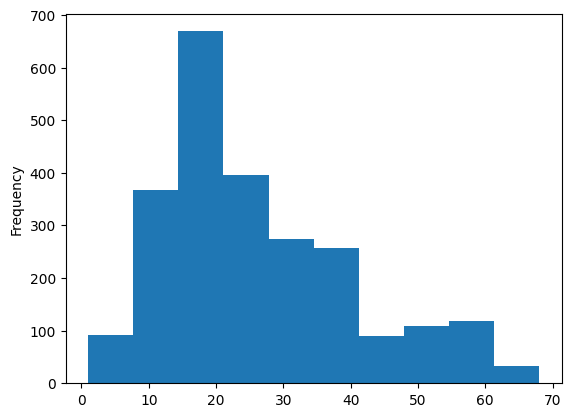

In [165]:
# Calculate the IQR range
Q1 = X_train['Tumor Size'].quantile(0.25)
Q3 = X_train['Tumor Size'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Tumor Size'
outliers_tumor_size = (X_train['Tumor Size'] < lower_bound) | (X_train['Tumor Size'] > upper_bound)

# Remove outliers from 'Tumor Size'
X_train = X_train[~outliers_tumor_size]
y_train = y_train[~outliers_tumor_size]

X_train['Tumor Size'].plot.hist()

<Axes: ylabel='Frequency'>

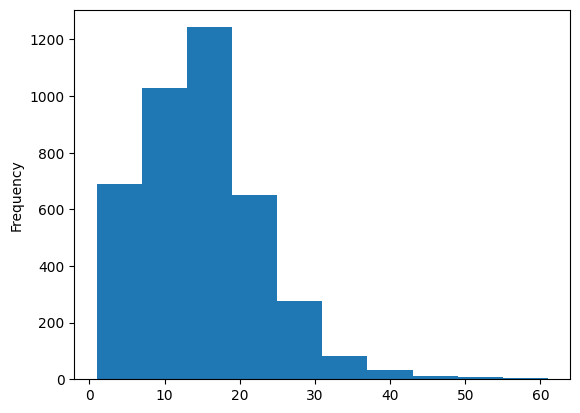

In [166]:
# Calculate the IQR range
Q1 = X_train['Regional Node Examined'].quantile(0.25)
Q3 = X_train['Regional Node Examined'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Regional Node Examined'
outliers_regional_node = (X_train['Regional Node Examined'] < lower_bound) | (X_train['Regional Node Examined'] > upper_bound)

# Remove outliers from 'Regional Node Examined'
X_train = X_train[~outliers_regional_node]
y_train = y_train[~outliers_regional_node]

df['Regional Node Examined'].plot.hist()

## Preprocessing

In [167]:
def preprocessing(X, y, scaler=None):
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X[numerical_cols] = scaler.transform(X[numerical_cols])
    # One Hot Encoding
    X = pd.get_dummies(X, columns = categorical_cols)
    # Encode output
    status_map = {'Dead': 1, 'Alive': 0}
    y = y.map(status_map)
    y = y.rename('Dead')
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val, y_val, scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

## Data Balancing

In [168]:
print('Original dataset shape:', Counter(y_train))

Original dataset shape: Counter({0: 2028, 1: 341})


In [169]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN for combined oversampling and undersampling
smote_enn = SMOTEENN(sampling_strategy='minority')
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print('Resampled dataset shape:', Counter(y_train))


Resampled dataset shape: Counter({1: 1705, 0: 1349})


## Support Functions

In [170]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

In [171]:
def compute_metrics(y_real,y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    f1 =f1_score(y_real,y_pred, pos_label=1)
    precision = precision_score(y_real, y_pred, pos_label=1)
    recall =recall_score(y_real,y_pred, pos_label=1)
    jaccard = jaccard_score(y_real, y_pred, pos_label=1)
    return [accuracy, f1, precision, recall, jaccard]

## LDA

In [172]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)
results_df.loc['LDA',:] = compute_metrics(y_val, y_pred_lda)
results_df

,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.82764,0.54321,0.458333,0.666667,0.372881


In [173]:
# Exploring LDA
X_transformed = lda_model.transform(X_train)

X_transformed = pd.DataFrame(X_transformed)
X_transformed['labels'] = y_train.reset_index(drop=True)
X_transformed

,0,labels
0,-1.536190,0
1,-0.559777,0
2,-2.433308,0
3,-0.585465,0
4,-1.357382,0
...,...,...
3049,-0.540115,1
3050,2.370806,1
3051,2.454844,1
3052,1.583060,1


<Axes: xlabel='0'>

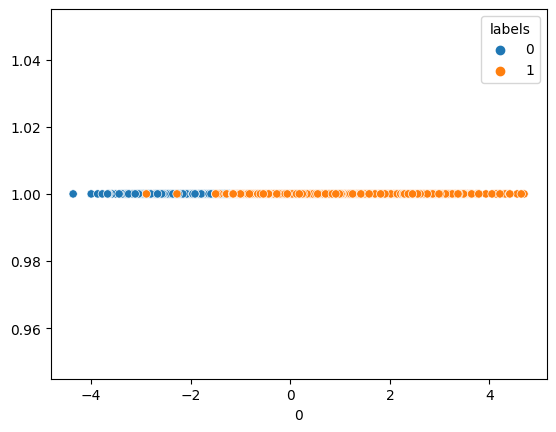

In [174]:
sns.scatterplot(x= 0, y= 1, data = X_transformed, hue='labels')

## KNN

In [175]:
from sklearn.neighbors import KNeighborsClassifier


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
results_knn = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

k_values = range(1,50,2)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred)

sorted_results_knn = results_knn.sort_values(by='Recall', ascending=False)
print(sorted_results_knn)

          Accuracy        F1 Precision    Recall   Jaccard
model k                                                   
KNN   11  0.667702  0.418478  0.286245  0.777778  0.264605
      15  0.670807  0.411111  0.283525  0.747475  0.258741
      49  0.636646  0.384211  0.259786  0.737374  0.237785
      19  0.681677  0.412607     0.288  0.727273  0.259928
      7   0.686335  0.416185  0.291498  0.727273  0.262774
      47  0.658385  0.392265  0.269962  0.717172  0.243986
      45  0.658385  0.392265  0.269962  0.717172  0.243986
      21  0.673913  0.403409  0.280632  0.717172  0.252669
      25  0.667702  0.398876  0.276265  0.717172  0.249123
      17  0.677019  0.405714  0.282869  0.717172   0.25448
      13  0.659938  0.393352  0.270992  0.717172  0.244828
      9   0.652174  0.387978  0.265918  0.717172  0.240678
      5   0.700311  0.423881  0.300847  0.717172  0.268939
      23  0.675466  0.401146      0.28  0.707071  0.250896
      3   0.698758  0.419162  0.297872  0.707071  0.2651

In [176]:

# Retrieve the k value of the first row
first_row = sorted_results_knn.iloc[0]
k_value = first_row.name[1]

print("k value of the first row:", k_value)

knn = KNeighborsClassifier(n_neighbors=k_value)
knn = knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_val)
results_df.loc['KNN-'+str(k_value), :] = compute_metrics(y_val, y_pred_knn)
results_df

k value of the first row: 11


,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.82764,0.54321,0.458333,0.666667,0.372881
KNN-11,0.667702,0.418478,0.286245,0.777778,0.264605


## Logistic Regression

In [177]:
from sklearn.linear_model import LogisticRegression


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'))
results_logreg = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C, max_iter=1000, random_state=42)
    logreg = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_val)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred)

sorted_results_logreg = results_logreg.sort_values(by='Recall', ascending=False)
print(sorted_results_logreg)

                 Accuracy        F1 Precision    Recall   Jaccard
model  C                                                         
LogReg 0.1       0.743789  0.489164  0.352679   0.79798   0.32377
       1.0       0.773292  0.493056  0.375661  0.717172  0.327189
       10.0      0.798137  0.511278  0.407186  0.686869  0.343434
       100000.0  0.798137  0.507576  0.406061  0.676768  0.340102
       10000.0   0.798137  0.507576  0.406061  0.676768  0.340102
       1000.0    0.798137  0.507576  0.406061  0.676768  0.340102
       100.0     0.796584   0.50566  0.403614  0.676768  0.338384


In [178]:
# Retrieve the k value of the first row
first_row = sorted_results_logreg.iloc[0]
c_value = first_row.name[1]

print("c value of the first row:", c_value)

logreg = LogisticRegression(C=c_value, max_iter=1000).fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_val)
results_df.loc['LogReg-'+str(c_value), :] = compute_metrics(y_val, y_pred_logreg)

results_df.sort_values(by='Recall', ascending=False)

c value of the first row: 0.1


,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.743789,0.489164,0.352679,0.79798,0.32377
KNN-11,0.667702,0.418478,0.286245,0.777778,0.264605
LDA,0.82764,0.54321,0.458333,0.666667,0.372881


## Random Forest

In [179]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='recall',
                           cv=5,
                           refit='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", grid_search.best_score_)

# Get the best model found by GridSearchCV
best_rfmodel = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9806451612903226


In [180]:
y_pred_rf = best_rfmodel.predict(X_val)
results_df.loc['Random Forest', :] = compute_metrics(y_val, y_pred_rf)

results_df.sort_values(by='Recall', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.743789,0.489164,0.352679,0.79798,0.32377
KNN-11,0.667702,0.418478,0.286245,0.777778,0.264605
Random Forest,0.790373,0.512635,0.398876,0.717172,0.34466
LDA,0.82764,0.54321,0.458333,0.666667,0.372881


## Feature Importance

<Axes: >

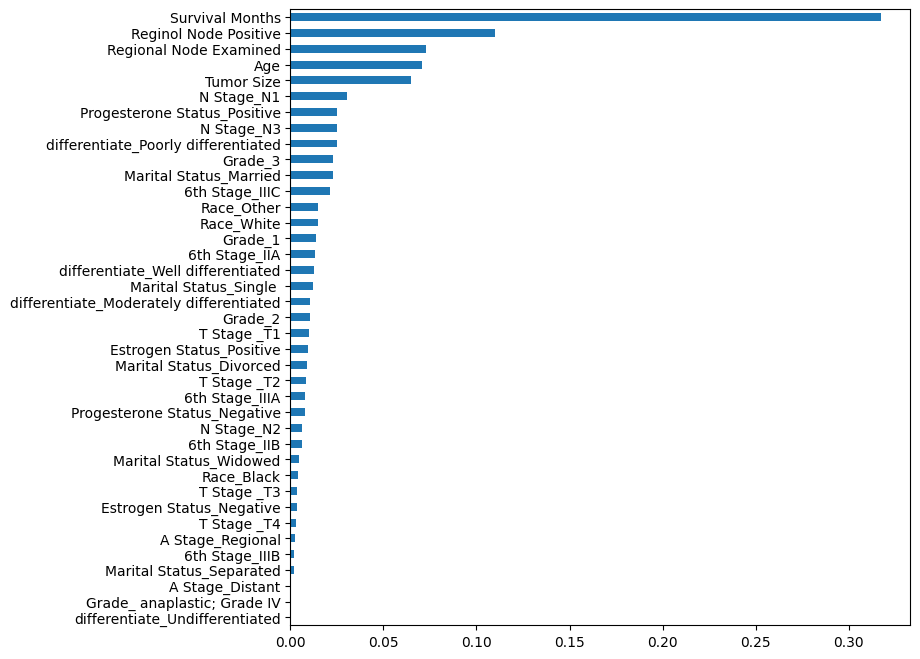

In [181]:
var_imp = pd.DataFrame({'importance': best_rfmodel.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

## Generalization Performance

In [182]:
logreg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
logreg = logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [183]:
print('accuracy_score: ',accuracy_score(y_test,y_pred))
print('recall_score: ',recall_score(y_test,y_pred))
print('jaccard_score: ',jaccard_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred))
print('precision_score: ',precision_score(y_test,y_pred))

fig = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),2), 
                template='ggplot2',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

accuracy_score:  0.7403726708074534
recall_score:  0.7479674796747967
jaccard_score:  0.30564784053156147
f1_score:  0.46819338422391854
precision_score:  0.34074074074074073
